<br>
<br>

![iteso](https://upload.wikimedia.org/wikipedia/en/5/5f/Western_Institute_of_Technology_and_Higher_Education_logo.png)

<strong>  InstitutoTecnológico y de Estudios Superiores de Occidente </strong>
<br />
<strong>  Maestría Ciencia de Datos  </strong>
<br />

# Optimización Convexa: Aplicación SVM para contra ingresos de HP Inc. #

<br>
<br>

* * *

David Cisneros, <br>
Carlos Manzo, <br>
Rodrigo Huerta, <br>
Juan Mario Ochoa, <br>
Daniel Nuño, daniel.nuno@iteso.mx <br>

Profesor: Dr. Juan Diego Sanchez Torres <br>
Fecha entrega: 11 de mayo, 2022 <br>

* * *

<br>
<br>

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import minmax_scale
from sklearn.svm import SVR
from sklearn.metrics.pairwise import (linear_kernel,polynomial_kernel,rbf_kernel)
import matplotlib.pyplot as plt

In [3]:
raw_data = pd.read_excel('https://github.com/dcisneroschavira/proyecto_oc/raw/main/BS%20by%20acc.xlsx')
raw_data.shape
raw_data.head()

,month,account,Total
0,2020-01,1202,6.757000e+01
1,2020-01,1206,-1.738018e+07
2,2020-01,2561,-3.805262e+08
3,2020-01,2569,-1.495655e+09
4,2020-01,2574,-3.402265e+07


## feature engineering

treat the month as date instead of string
accomodate so we have one variable for each variable
use the month data as index
and scale between 0 to 1

In [97]:
data = raw_data.copy()
data.month = data.month + '-01'
data['month'] = pd.to_datetime(data['month'])
data.account = data['account'].astype('str')
data = data.pivot(index=['month'], columns=['account'], values=['Total'])
data = data.droplevel(0, axis=1)
data = data[['1206', '2561', '2569', '2574', '2575', '2576', '2577', '2582']]

periods = np.arange(len(data)).reshape(-1,1)

data_index = pd.date_range(start=data.index.min(),
                            end=data.index.max(),
                            freq='M')

data = data.fillna(axis=1, method='backfill')

data_scale = pd.DataFrame(minmax_scale(data), index=data.index, columns=data.columns)

<AxesSubplot:xlabel='month'>

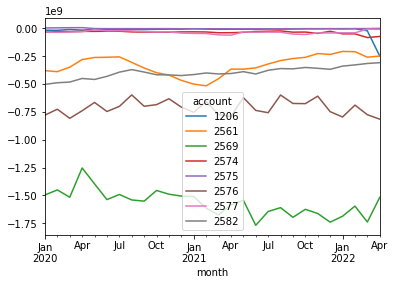

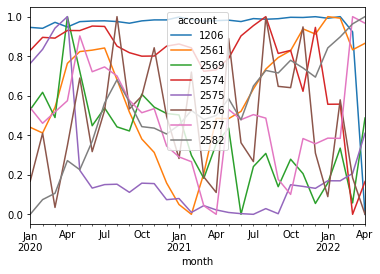

In [99]:
data.plot()
data_scale.plot()

## 2569 linear kernel

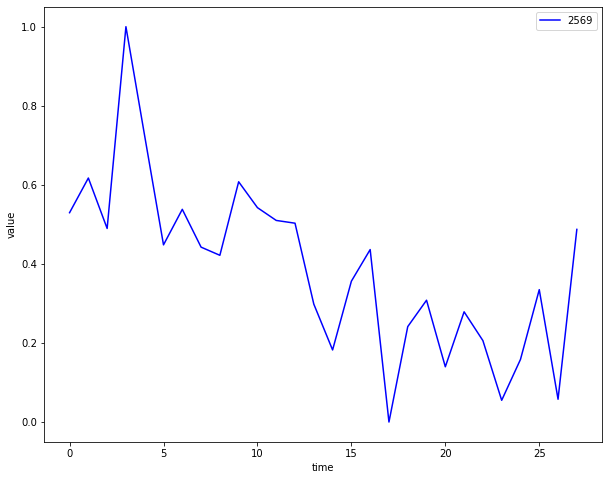

In [71]:
a_2569 = data_scale['2569'].values
y = data_scale['2569'].values.ravel()
X = periods

plt.figure(figsize=(10,8))
plt.plot(X, y, c='b', label='2569')
plt.xlabel('time')
plt.ylabel('value')
plt.legend()
plt.show()

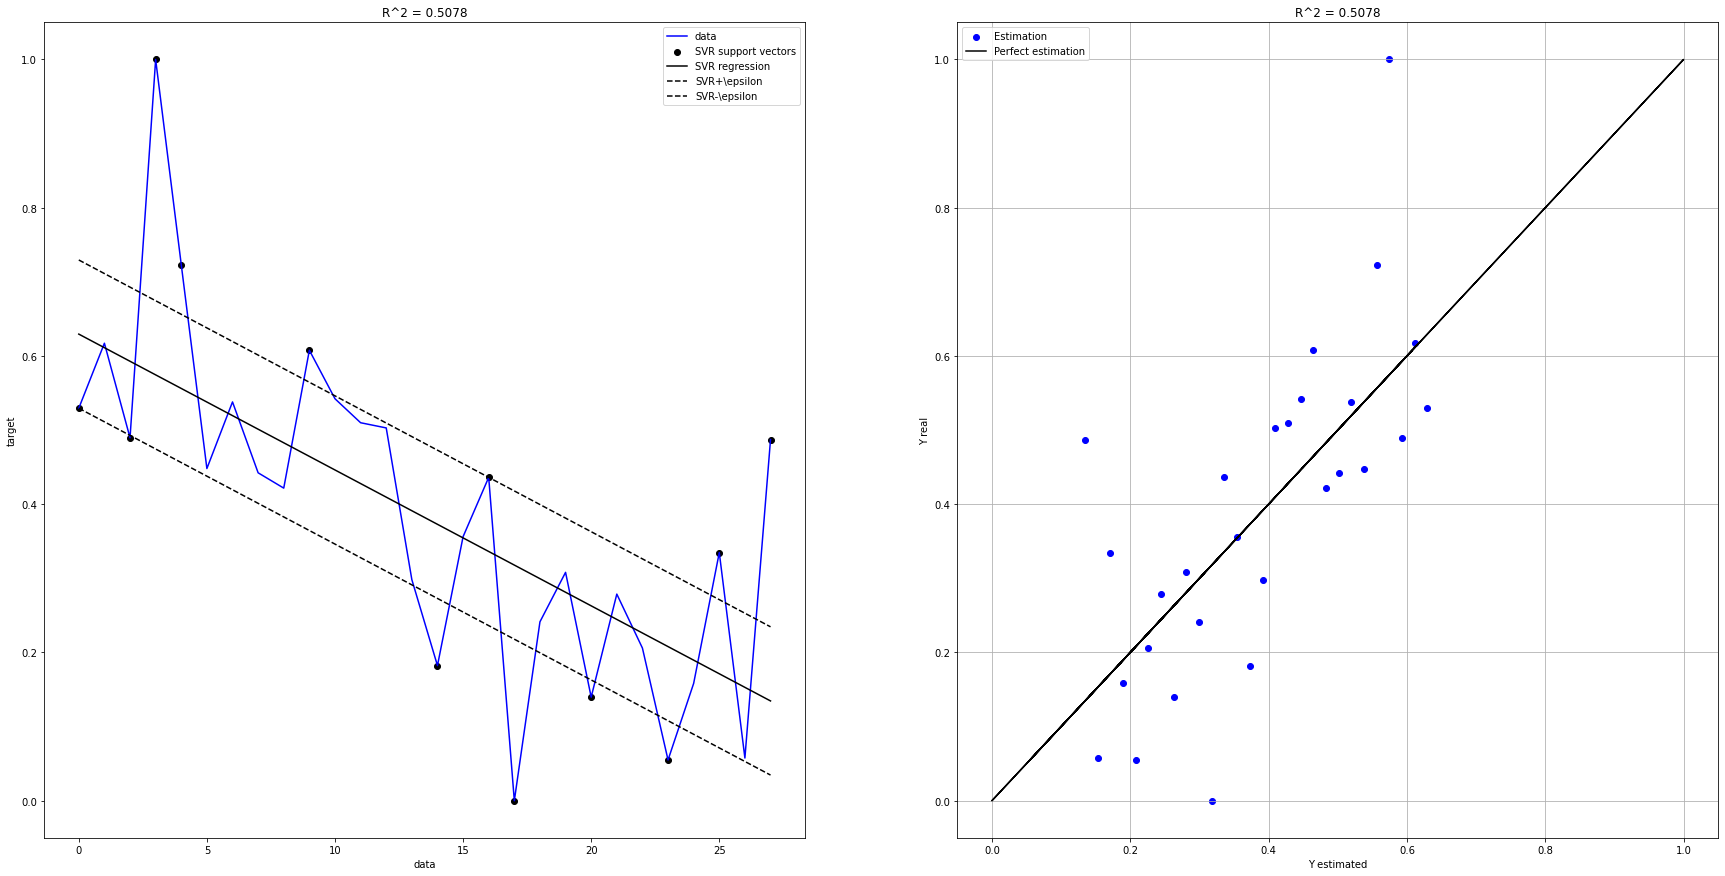

In [64]:
# kernel transformation
K_x = linear_kernel(X)

# params
epsilon = 0.1

# creating a SVR model class
model_svr = SVR(kernel='linear', epsilon=epsilon,)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.support_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

#%% Prediction using the optimization problem results.
alphas = model_svr.dual_coef_
x_sv = model_svr.support_vectors_
b = model_svr.intercept_
# Needs the correct Kernel
K_x = linear_kernel(x_sv, X)
Y_p = np.dot(alphas, K_x) + b

# View the results
fig = plt.figure(figsize=(30,15))
plt.subplot(1,2,1)
plt.plot(X, y, c='b', label='data')
plt.scatter(X[sv_x], y[sv_x], c='k', label='SVR support vectors', zorder=1,edgecolors=(0, 0, 0))
plt.plot(X, Y_plot, c='k',label='SVR regression')
plt.plot(X, Y_plot+epsilon, c='k', linestyle='dashed',label='SVR+\epsilon')
plt.plot(X, Y_plot-epsilon, c='k', linestyle='dashed',label='SVR-\epsilon')
plt.xlabel('data')
plt.ylabel('target')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()

plt.subplot(1,2,2)
plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()


## uisng the other accounts as input x

In [222]:
a_2569 = data_scale['2569'].values
y = data_scale['2569'].values.ravel()
X = data[list(set(data_scale.columns) - set('2569'))].values
X = data_scale[list(set(data_scale.columns) - set('2569'))].values
X = np.column_stack((X, periods))

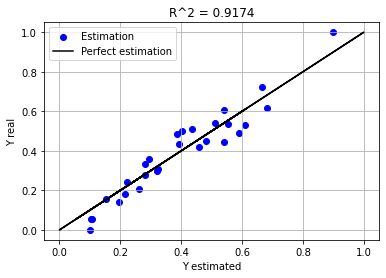

In [223]:
# kernel transformation
K_x = linear_kernel(X)

# params
epsilon = 0.1

# creating a SVR model class
model_svr = SVR(kernel='linear', epsilon=epsilon)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.support_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

#%% Prediction using the optimization problem results.
alphas = model_svr.dual_coef_
x_sv = model_svr.support_vectors_
b = model_svr.intercept_
# Needs the correct Kernel
K_x = linear_kernel(x_sv, X)
Y_p = np.dot(alphas, K_x) + b

# View the results

plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()

## 2569 linear kernel with lags

reshape the existing train_data and test_data such that there is a new dimension which refers to the timesteps.
For this example, we take lags = 3. So, the inputs to the model are the data for the first 2 timesteps, and the output will be the data for the 3th timestep.
3 because of the quarter periodicity.
se pierden las tres dos primeras observaciones.

In [236]:
timesteps = 3
train_data = data_scale['2569'].values.reshape(-1, 1)

train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape

(26, 3)

In [239]:
X, y = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,[timesteps-1]]
y = y.ravel()
X_others = data_scale[list(set(data_scale.columns) - set('2569'))].values[timesteps-1:,:]
X = np.column_stack((periods[timesteps-1:], X, X_others))
#X = np.column_stack((periods[timesteps-1:], X))
X.shape

(26, 11)

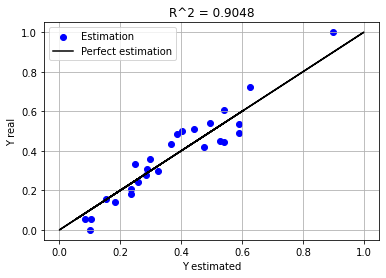

In [240]:
# kernel transformation
K_x = linear_kernel(X)

# params
epsilon = 0.1

# creating a SVR model class
model_svr = SVR(kernel='linear', epsilon=epsilon)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.support_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

#%% Prediction using the optimization problem results.
alphas = model_svr.dual_coef_
x_sv = model_svr.support_vectors_
b = model_svr.intercept_
# Needs the correct Kernel
K_x = linear_kernel(x_sv, X)
Y_p = np.dot(alphas, K_x) + b

# View the results

plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()

## using rbf kernels

In [171]:
timesteps = 3
train_data = data_scale['2569'].values.reshape(-1, 1)

train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
train_data_timesteps.shape
X, y = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,[timesteps-1]]
y = y.ravel()
X_others = data_scale[list(set(data_scale.columns) - set('2569'))].values[timesteps-1:,:]
X = np.column_stack((periods[timesteps-1:], X, X_others))
X.shape

(26, 11)

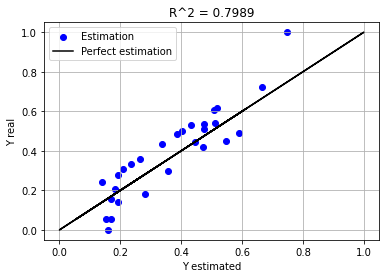

In [225]:
# kernel transformation
#polynomial_kernel,rbf_kernel
K_x = rbf_kernel(X)

# params
epsilon = 0.1
gamma = 'auto'
kernel = 'rbf'

# creating a SVR model class
model_svr = SVR(kernel=kernel, epsilon=epsilon, gamma=gamma)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.support_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

#%% Prediction using the optimization problem results.
alphas = model_svr.dual_coef_
x_sv = model_svr.support_vectors_
b = model_svr.intercept_
# Needs the correct Kernel
K_x = rbf_kernel(x_sv, X)
Y_p = np.dot(alphas, K_x) + b

# View the results

plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()

## using poly

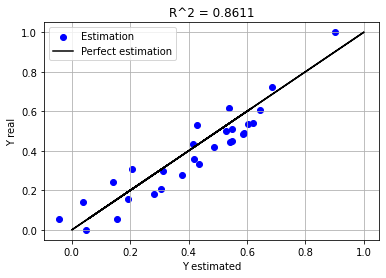

In [226]:
# kernel transformation
K_x = polynomial_kernel(X)

# params
epsilon = 0.1
gamma = 'auto'
kernel = 'poly'
C = 100

# creating a SVR model class
model_svr = SVR(kernel=kernel, gamma=gamma, epsilon=epsilon, degree=3, coef0=1)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.support_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

#%% Prediction using the optimization problem results.
alphas = model_svr.dual_coef_
x_sv = model_svr.support_vectors_
b = model_svr.intercept_
# Needs the correct Kernel
K_x = polynomial_kernel(x_sv, X)
Y_p = np.dot(alphas, K_x) + b

# View the results

plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()

## using lssvm regression

In [175]:
# -*- coding: utf-8 -*-
"""
Created on Tue May 19 09:27:21 2020
An LS-SVM regression class following the sk-learn API.
_                         _   _   _    _  _
| 0          1^T_N         |  | b  |   | 0 |
|                          |  |    | = |   |
| 1_N  Omega+gamma^-1 I_N  |  | a  |   | Y |
|_                        _|  |_  _|   |_ _|
Omega= Kernel K(x_i,x_j)
gamma= hyper-parameter (is a ratio z/µ with z the sum squared error and µ the
                        amount of regularization)
1_N = vector (1,1,1,..,1)
I_N = NxN unity matrix
@author: Dr. Dr. Danny E. P. Vanpoucke
@web   : https://dannyvanpoucke.be
"""
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin


class LSSVMRegression(BaseEstimator, RegressorMixin):
    """
    An Least Squared Support Vector Machine (LS-SVM) regression class, build
    on the BaseEstimator and RegressorMixin base classes of sklearn.
    (Let's hope furture upgrades of python sk-learn just doesn't break this...
    consider this a python feature)
    Attributes:
        - gamma : the hyper-parameter (float)
        - kernel: the kernel used     (string)
        - kernel_: the actual kernel function
        - x : the data on which the LSSVM is trained (call it support vectors)
        - y : the targets for the training data
        - coef_ : coefficents of the support vectors
        - intercept_ : intercept term
    """
    def __init__(self, gamma: float = 1.0, kernel: str = None, c: float = 1.0,
                 d: float = 2, sigma: float = 1.0):
        """
        Create a new regressor
        Parameters:
            - gamma: floating point value for the hyper-parameter gamma, DEFAULT=1.0
            - kernel: string indicating the kernel: {'linear','poly','rbf'}, DEFAULT='rbf'
            - the kernel parameters
                    * linear: none
                    * poly:
                        + c: scaling constant, DEFAULT=1.0
                        + d: polynomial power, DEFAULT=2
                    * rbf:
                        + sigma: scaling constant, DEFAULT=1.0
        """
        self.gamma = gamma
        self.c = c
        self.d = d
        self.sigma = sigma
        if kernel is None:
            self.kernel = 'rbf'
        else:
            self.kernel = kernel

        params = dict()
        if kernel == 'poly':
            params['c'] = c
            params['d'] = d
        elif kernel == 'rbf':
            params['sigma'] = sigma

        self.kernel_ = LSSVMRegression.__set_kernel(self.kernel, **params)

        #model parameters
        self.x = None
        self.y = None
        self.coef_ = None
        self.intercept_ = None

    def get_params(self, deep=True):
        """
            The get_params functionality provides the parameters of the LSSVMRegression class.
            These exclude the modelparameters.
        """
        return {"c": self.c, "d": self.d, "gamma": self.gamma,
                "kernel": self.kernel, "sigma":self.sigma}

    def set_params(self, **parameters):
        """
            Set the parameters of the class. Important note: This should do
            anything that is done to relevant parameters in __init__ as
            sklearn's GridSearchCV uses this instead of init.
            More info:  https://scikit-learn.org/stable/developers/develop.html
        """
        #print("SETTING PARAMETERS IN LSSVM:",parameters.items())

        for parameter, value in parameters.items():
            #setattr should do the trick for gamma,c,d,sigma and kernel
            setattr(self, parameter, value)
        #now also update the actual kernel
        params = dict()
        if self.kernel == 'poly':
            params['c'] = self.c
            params['d'] = self.d
        elif self.kernel == 'rbf':
            params['sigma'] = self.sigma
        self.kernel_ = LSSVMRegression.__set_kernel(self.kernel, **params)

        return self

    def set_attributes(self, **parameters):
        """
            Manually set the attributes of the model. This should generally
            not be done, except when testing some specific behaviour, or
            creating an averaged model.
            Parameters are provided as a dictionary.
                - 'intercept_' : float intercept
                - 'coef_'      : float array of coefficients
                - 'support_'   : array of support vectors, in the same order sorted
                                 as the coefficients
        """
        #not the most efficient way of doing it...but sufficient for the time being
        for param, value in parameters.items():
            if param == 'intercept_':
                self.intercept_ = value
            elif param == 'coef_':
                self.coef_ = value
            elif param == 'support_':
                self.x = value

    @staticmethod
    def __set_kernel(name: str, **params):
        """
            Internal static function to set the kernel function.
            NOTE: The second "vector" xj will be the one which generally
                  contains an array of possible vectors, while xi should be a single
                  vector. Therefore, the numpy dot-product requires xj to
                  be transposed.
            The kernel returns either a scalar or a numpy nd-array of
            rank 1 (i.e. a vector), if it returns something else the result
            is wrong if xi is an array.
        """
        def linear(xi, xj):
            """
               v*v=scal (dot-product OK)
               v*m=v    (dot-product OK)
               m*m=m    (matmul for 2Dx2D, ok with dot-product)
            """
            return np.dot(xi, xj.T)

        def poly(xi, xj, c=params.get('c', 1.0), d=params.get('d', 2)):
            """
                Polynomial kernel ={1+ (xi*xj^T)/c }^d
                Parameters:
                    - c: scaling constant, DEFAULT=1.0
                    - d: polynomial power, DEFAULT=2
                    - xi and xj are numpy nd-arrays
                (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )
                works on same as linear
            """
            return ((np.dot(xi, xj.T))/c  + 1)**d

        def rbf(xi, xj, sigma=params.get('sigma', 1.0)):
            """
            Radial Basis Function kernel= exp(- ||xj-xi||² / (2*sigma²))
            In this formulation, the rbf is also known as the Gaussian kernel of variance sigma²
            As the Euclidean distance is strict positive, the results of this kernel
            are in the range [0..1] (x € [+infty..0])
            Parameters:
                - sigma: scaling constant, DEFAULT=1.0
                - xi and xj are numpy nd-arrays
            (cf: https://en.wikipedia.org/wiki/Least-squares_support-vector_machine )
            Possible combinations of xi and xj:
                vect & vect   -> scalar
                vect & array  -> vect
                array & array -> array => this one requires a pair distance...
                                    which can not be done with matmul and dot
                The vectors are the rows of the arrays (Arr[0,:]=first vect)
                The squared distance between vectors= sqr(sqrt( sum_i(vi-wi)² ))
                --> sqr & sqrt cancel
                --> you could use a dot-product operator for vectors...but this
                seems to fail for nd-arrays.
            For vectors:
                ||x-y||²=sum_i(x_i-y_i)²=sum_i(x²_i+y²_i-2x_iy_i)
                --> all products between vectors can be done via np.dot: takes the squares & sum
            For vector x and array of vectors y:
                --> x²_i : these are vectors: dot gives a scalar
                --> y²_i : this should be a list of scalars, one per vector.
                            => np.dot gives a 2d array
                            => so   1) square manually (squares each element)
                                    2) sum over every row (axis=1...but only in case we
                                                           have a 2D array)
                --> x_iy_i : this should also be a list of scalars. np.dot does the trick,
                            and even gives the same result if matrix and vector are exchanged
            for array of vectors x and array of vectors y:
                --> either loop over vectors of x, and for each do the above
                --> or use cdist which calculates the pairwise distance and use that in the exp
            """
            from scipy.spatial.distance import cdist

           # print('LS_SVM DEBUG: Sigma=',sigma,'  type=',type(sigma) )
           # print('              xi   =',xi,'  type=',type(xi))
           # print('              xj   =',xj,'  type=',type(xj))


            if (xi.ndim == 2 and xi.ndim == xj.ndim): # both are 2D matrices
                return np.exp(-(cdist(xi, xj, metric='sqeuclidean'))/(2*(sigma**2)))
            elif ((xi.ndim < 2) and (xj.ndim < 3)):
                ax = len(xj.shape)-1 #compensate for python zero-base
                return np.exp(-(np.dot(xi, xi) + (xj**2).sum(axis=ax)
                                - 2*np.dot(xi, xj.T))/(2*(sigma**2)))
            else:
                message = "The rbf kernel is not suited for arrays with rank >2"
                raise Exception(message)

        kernels = {'linear': linear, 'poly': poly, 'rbf': rbf}
        if kernels.get(name) is not None:
            return kernels[name]
        else: #unknown kernel: crash and burn?
            message = "Kernel "+name+" is not implemented. Please choose from : "
            message += str(list(kernels.keys())).strip('[]')
            raise KeyError(message)

    def __OptimizeParams(self):
        """
        Solve the matrix operation to get the coefficients.
        --> equation 3.5 and 3.6 of the book by Suykens
        ==> that is for classification, for regression slightly different cf Dilmen paper 2017
        self.y: 1D array
        self.X: 2D array (with rows the vectors: X[0,:] first vector)
        Set the class parameters:
            - self.intercept_ : intercept
            - self.coef_      : coefficients
        """
        #eq 3.6: Omega_kl = y_ky_lK(x_k,x_l)
        # !! note that the product of a vector and the transposed is a dot-product
        #    and we need an outer product
        #For classification and Regression, the matrices are slightly different...
        # (why? except for what came out of solving equations?
        # Dilmen et al, IFAC PapersOnline 50(1), 8642-8647 (2017))

        # Classification
        # Omega = np.multiply( np.multiply.outer(y,y), self.kernel_(X,X) ) # correct version
        #A_dag = np.linalg.pinv(np.block([
        #    [0,                           y.T                   ],
        #    [y,   Omega + self.gamma**-1 * np.eye(len(y_values))]
        #])) #need to check if the matrix is OK--> y.T parts
        #B = np.array([0]+[1]*len(y_values))

        #Regression
        Omega = self.kernel_(self.x, self.x)
        Ones = np.array([[1]]*len(self.y)) # needs to be a 2D 1-column vector, hence [[ ]]

        A_dag = np.linalg.pinv(np.block([
            [0,                           Ones.T                      ],
            [Ones,   Omega + self.gamma**-1 * np.identity(len(self.y))]
        ])) #need to check if the matrix is OK--> y.T parts
        B = np.concatenate((np.array([0]), self.y), axis=None)

        solution = np.dot(A_dag, B)
        self.intercept_ = solution[0]
        self.coef_      = solution[1:]


    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the parameters based on the support vectors X (and store these as they are
        parameters of the LS-SVM as well, because needed for prediction)
        We are doing Regression.
        Parameters:
            - X : 2D array of vectors (1 per row: X[0,:] first vector)
            - y : 1D vector of targets
        """

        #print("IN FIT==> GAMMA=",self.gamma,"  SIGMA=",self.sigma)

        if isinstance(X, (pd.DataFrame, pd.Series)): #checks if X is an instance of either types
            Xloc = X.to_numpy()
        else:
            Xloc = X

        if isinstance(y, (pd.DataFrame, pd.Series)):
            yloc = y.to_numpy()
        else:
            yloc = y

        #check the dimensionality of the input
        if (Xloc.ndim == 2) and (yloc.ndim == 1):
            self.x = Xloc
            self.y = yloc
            self.__OptimizeParams()
        else:
            message = "The fit procedure requires a 2D numpy array of features "\
                "and 1D array of targets"
            raise Exception(message)

    def predict(self, X: np.ndarray)->np.ndarray:
        """
        Predict the regression values for a set of feature vectors
        Parameters:
            - X: ndarray of feature vectors (max: 2D), 1 per row if more than one.
        """
        Ker = self.kernel_(X, self.x) #second component should be the array of training vectors
        Y = np.dot(self.coef_, Ker.T) + self.intercept_
        return Y

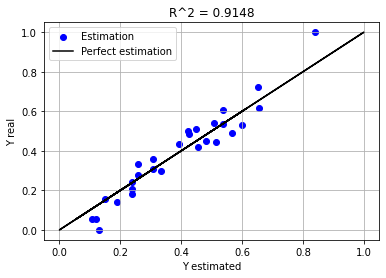

In [227]:
# params
epsilon = 0.1
gamma = 2
kernel = 'linear'
C = 100

# creating a SVR model class
model_svr = LSSVMRegression(kernel=kernel, gamma=gamma)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.coef_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

# View the results

plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()

this class doesn't have the same attributes nor properties that the ones from sklearn so cannot calculate the dual optimization nor the support vectors as easily.
## lags from the other series
now, what if we use the other series lags for inputs for the next period data.



In [253]:
timesteps = 3
train_data = data_scale['2569'].values.reshape(-1, 1)

#train_data_timesteps = np.array([[j for j in train_data[i:i+timesteps]] for i in range(0,len(train_data)-timesteps+1)])[:,:,0]
#train_data_timesteps.shape
#X, y = train_data_timesteps[:,:timesteps-1], train_data_timesteps[:,[timesteps-1]]
y = train_data
y = y.ravel()

X_others = data_scale[list(set(data_scale.columns) - set('2569'))].values[timesteps-2:-1,:]

#X = np.column_stack((periods[timesteps-1:], X, X_others))
X = np.column_stack((periods[timesteps-1:], X_others))
y.shape

(28,)

In [257]:
y = data_scale['2569'].values[1:]
y.shape
X_others = data_scale[list(set(data_scale.columns) - set('2569'))].values[:-1,:]
X = np.column_stack((periods[1:], X_others))

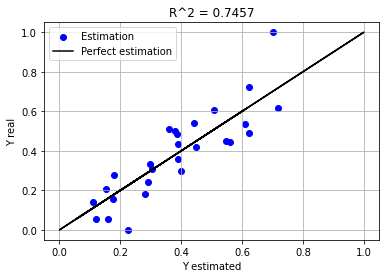

In [258]:
# kernel transformation
K_x = linear_kernel(X)

# params
epsilon = 0.1

# creating a SVR model class
model_svr = SVR(kernel='linear', epsilon=epsilon)
# Step 2. Training the model
model_svr.fit(X, y)
# Step 3. Using the model
y_hat = model_svr.predict(X)
# Step 4. Evaluation of results
sv_x = model_svr.support_
R2 = model_svr.score(X,y)
Y_plot = model_svr.predict(X)

#%% Prediction using the optimization problem results.
alphas = model_svr.dual_coef_
x_sv = model_svr.support_vectors_
b = model_svr.intercept_
# Needs the correct Kernel
K_x = linear_kernel(x_sv, X)
Y_p = np.dot(alphas, K_x) + b

# View the results

plt.scatter(y_hat, y, c='b', label='Estimation')
plt.plot(y, y, c='k', label='Perfect estimation')
plt.xlabel('Y estimated')
plt.ylabel('Y real')
plt.title('R^2 = %0.4f'%model_svr.score(X,y))
plt.legend()
plt.grid()
plt.show()